In [1]:
# import of necessary libraries
import openeo
import logging
import json

In [2]:
# define connetion parameters 
service_endpoint = "https://openeo.eurac.edu"
user = "guest"
password = "guest_123"

# authenticate with service endpoint
con = openeo.connect(service_endpoint)
con.authenticate_basic(user, password)
con.describe_account()

{'links': [{'href': 'https://openeo.eurac.edu/me', 'rel': 'self'}],
 'user_id': 'guest'}

In [3]:
# get some information about available functionality
cap = con.capabilities()
print(cap.version())
print(cap.list_features())
print(cap.currency())
print(cap.list_plans())

0.4.2
[{'methods': ['GET'], 'path': '/'}, {'methods': ['GET'], 'path': '/.well-known/openeo'}, {'methods': ['GET'], 'path': '/credentials/basic'}, {'methods': ['GET'], 'path': '/credentials/oidc'}, {'methods': ['GET'], 'path': '/me'}, {'methods': ['GET'], 'path': '/output_formats'}, {'methods': ['GET'], 'path': '/collections'}, {'methods': ['GET'], 'path': '/udf_runtimes'}, {'methods': ['GET'], 'path': '/collections/{collection_id}'}, {'methods': ['GET'], 'path': '/processes'}, {'methods': ['GET', 'POST'], 'path': '/jobs'}, {'methods': ['GET', 'POST'], 'path': '/result'}, {'methods': ['GET', 'PATCH', 'DELETE'], 'path': '/jobs/{job_id}'}, {'methods': ['GET', 'POST'], 'path': '/jobs/{job_id}/results'}, {'methods': ['GET', 'POST'], 'path': '/process_graphs'}, {'methods': ['GET', 'PATCH', 'DELETE'], 'path': '/process_graphs/{process_graph_id}'}, {'methods': ['GET'], 'path': '/files/{user_id}'}, {'methods': ['GET', 'PUT', 'DELETE'], 'path': '/files/{user_id}/{path}'}]
None
None


In [4]:
# load a specific dataset
datacube = con.load_collection(collection_id="openEO_S2_32632_10m_L2A_D22", bands=['B02', 'B03', 'B04', 'B08'])
# perform spatial subsetting (e.g around the city of Bolzano)
datacube = datacube.filter_bbox(west=11.279182434082033, south=46.464349400461145, 
                                east=11.406898498535158, north=46.522729291844286, crs="EPSG:32632")
# perform temporal subsetting (e.g. for the month of june in 2018, only this data available in this collection)
temp = datacube.filter_temporal(extent=["2018-06-06T00:00:00Z", "2018-06-22T00:00:00Z"])
# map features of the dataset to variables (e.g. the red and near infrared band)
red = temp.band('B04')
nir = temp.band("B08")
# perform operation using feature variables (e.g. calculation of NDVI (normalized difference vegetation index))
datacube = (nir - red) / (nir + red)
# reduce on temporal dimension with max operator
datacube = datacube.max_time()
# provide result as geotiff image
datacube = datacube.save_result(format="gtiff")

In [5]:
# have a look at your process graph (not necessary and only for demonstration purposes)
print(json.dumps(datacube.graph,indent=2))

{
  "loadcollection1": {
    "process_id": "load_collection",
    "result": false,
    "arguments": {
      "id": "S2_L2A_T32TPS_20M",
      "spatial_extent": null,
      "temporal_extent": null,
      "bands": [
        "AOT",
        "B02",
        "B03",
        "B04",
        "B05",
        "B06",
        "B07",
        "B8A",
        "B11",
        "B12",
        "SCL",
        "VIS",
        "WVP",
        "CLD",
        "SNW"
      ]
    }
  },
  "saveresult1": {
    "process_id": "save_result",
    "result": false,
    "arguments": {
      "data": {
        "from_node": "reduce3"
      },
      "options": {},
      "format": "gtiff"
    }
  },
  "reduce3": {
    "process_id": "reduce",
    "result": false,
    "arguments": {
      "data": {
        "from_node": "reduce2"
      },
      "reducer": {
        "callback": {
          "r1": {
            "process_id": "max",
            "result": true,
            "arguments": {
              "data": {
                "from_argument

In [6]:
# submit your process graph as new batch job to back-end
job = datacube.send_job()

In [7]:
# launch processing of submitted batch job
if job.job_id:
    print(job.job_id)
    print(job.start_job())
    print (job.describe_job())
else:
    print("Job ID is None")

2b26d8f8-c3fc-4521-8cd9-ff62f064b777
None
{'status': 'finished', 'id': '2b26d8f8-c3fc-4521-8cd9-ff62f064b777', 'updated': '2020-02-04T09:43:34.933Z', 'title': None, 'progress': None, 'description': None, 'costs': None, 'submitted': '2020-02-04T09:43:31.577Z', 'process_graph': {'filterbbox1': {'result': False, 'process_id': 'filter_bbox', 'arguments': {'data': {'from_node': 'loadcollection1'}, 'extent': {'east': 11.406898498535158, 'south': 46.464349400461145, 'crs': 'EPSG:32632', 'west': 11.279182434082033, 'north': 46.522729291844286}}}, 'saveresult1': {'result': True, 'process_id': 'save_result', 'arguments': {'data': {'from_node': 'reduce3'}, 'options': {}, 'format': 'gtiff'}}, 'reduce3': {'result': False, 'process_id': 'reduce', 'arguments': {'data': {'from_node': 'reduce2'}, 'reducer': {'callback': {'r1': {'result': True, 'process_id': 'max', 'arguments': {'data': {'from_argument': 'data'}}}}}, 'dimension': 'temporal'}}, 'reduce2': {'result': False, 'process_id': 'reduce', 'argume

In [8]:
# obtain results and save to disk
if job.job_id:
    job.download_results("Sentinel2STfile.tiff")

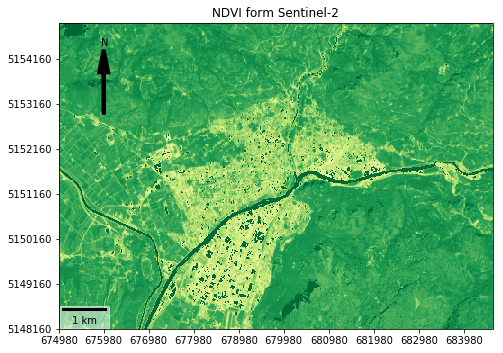

In [9]:
# Visualize your result
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import NoNorm
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
from osgeo import gdal

%matplotlib inline

image_ds = gdal.Open("Sentinel2STfile.tiff")
ndvi_band = image_ds.GetRasterBand(1)
ndvi_image = ndvi_band.ReadAsArray()

dpi = 80
height, width = ndvi_image.shape

# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)

fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])

# Hide spines, ticks, etc.
ax.axis('on')

# Get geo extent using gdal
ext = image_ds.GetGeoTransform()
ncol = image_ds.RasterXSize
nrow = image_ds.RasterYSize
x_min = ext[0]
x_max = ext[0] + ext[1] * ncol
y_min = ext[3] + ext[5] * nrow
y_max = ext[3]

#plot map info elements
plt.xticks(np.arange(x_min, x_max, 1000))
plt.yticks(np.arange(y_min, y_max, 1000))
scalebar = ScaleBar(1, location='lower left', box_alpha=0.5)
plt.gca().add_artist(scalebar)
plt.arrow(x_min+1000,y_max-2000,0,900,fc="k", ec="k", linewidth = 4, head_width=200, head_length=500)
plt.text(x_min+950, y_max-500, 'N')
plt.title("NDVI form Sentinel-2")

# Display the image.
ax.imshow(ndvi_image, cmap='RdYlGn',vmin=-1,vmax=1, extent=[x_min, x_max, y_min, y_max])

